# Differential abundance analysis

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings(action="ignore")

import data_support as sup
import matplotlib.pyplot as plt
import numpy as np
import protvi
import protvi.plots as pl
import scanpy as sc
import scvi

scvi.settings.seed = 0

Seed set to 0


Let"s load the data.

In [4]:
adata = sc.read_h5ad("../../data/processed/manns_inhouse.h5ad")

Let's now train the model.

In [5]:
adata.X = adata.layers["main"].copy()
adata.X[np.isnan(adata.X)] = 0

In [6]:
protvi.model.PROTVI.setup_anndata(adata, batch_key="Plate", continuous_covariate_keys=["log Qalb"])

model = protvi.model.PROTVI(adata, log_variational=False, decoder_type="selection", n_hidden=32)
# model.view_anndata_setup()

Let's train the model.

In [5]:
model.train(
    max_epochs=500,
    plan_kwargs={"mechanism_weight": 1, "min_kl_weight": 0, "max_kl_weight": 0.1},
    check_val_every_n_epoch=1,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 500/500: 100%|██████████| 500/500 [05:11<00:00,  1.42it/s, v_num=1, train_loss_step=817, train_loss_epoch=795]        

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [05:11<00:00,  1.61it/s, v_num=1, train_loss_step=817, train_loss_epoch=795]


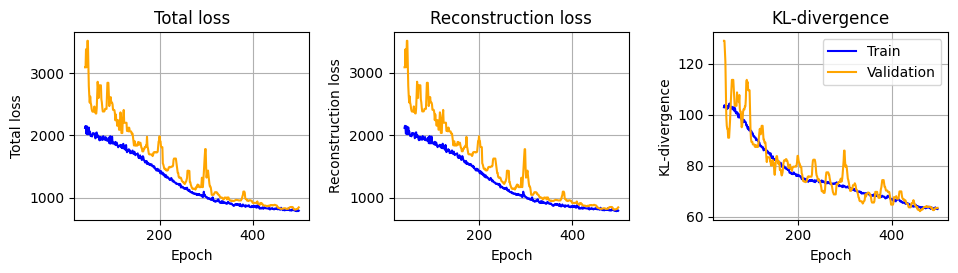

In [7]:
pl.plot_loss(model.history, epoch_start=40, validation_smooth_window=10)

In [8]:
model.save("protvi_checkpoint")

### Evaluation on training set (MAIN)

In [7]:
model = protvi.model.PROTVI.load("protvi_checkpoint", adata)

INFO     File protvi_checkpoint/model.pt already downloaded                                                        


In [10]:
x_est, p_est = model.impute(n_samples=100)

x_main = adata.layers["main"]
x_pilot = adata.layers["pilot"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_main)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_main)] = np.nan

Let's look at the predicted detection probability for each protein, and compare it to the observed missingness.

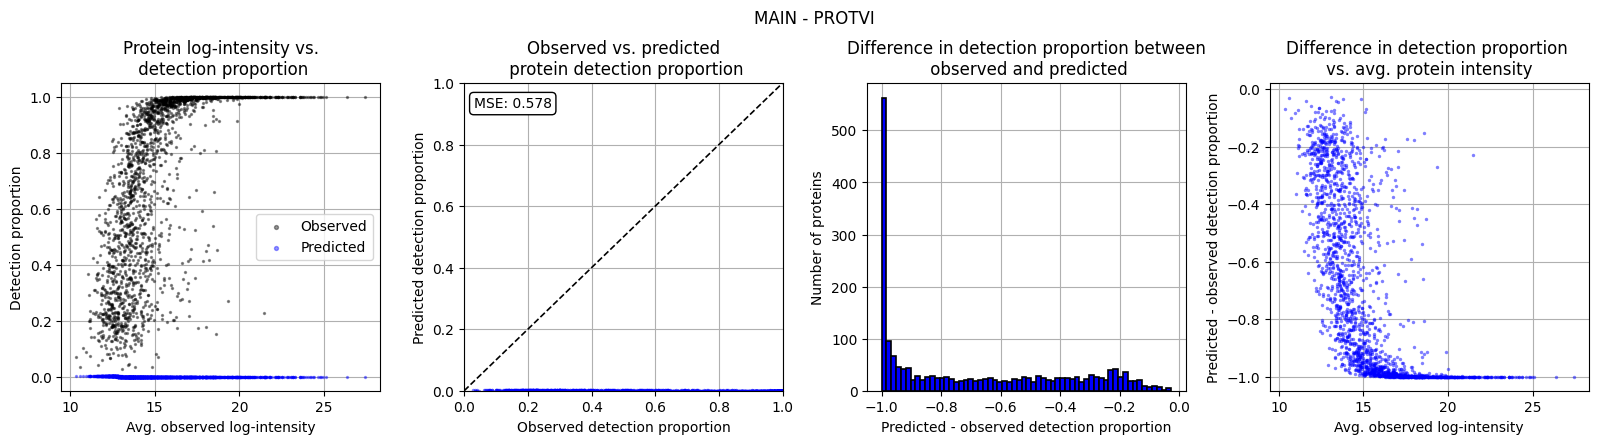

In [11]:
pl.plot_protein_detection_proportion_panel(x_main, p_est, title="MAIN - PROTVI")

Let's now compare the protein intensities predicted by the model and the intensities in MAIN.

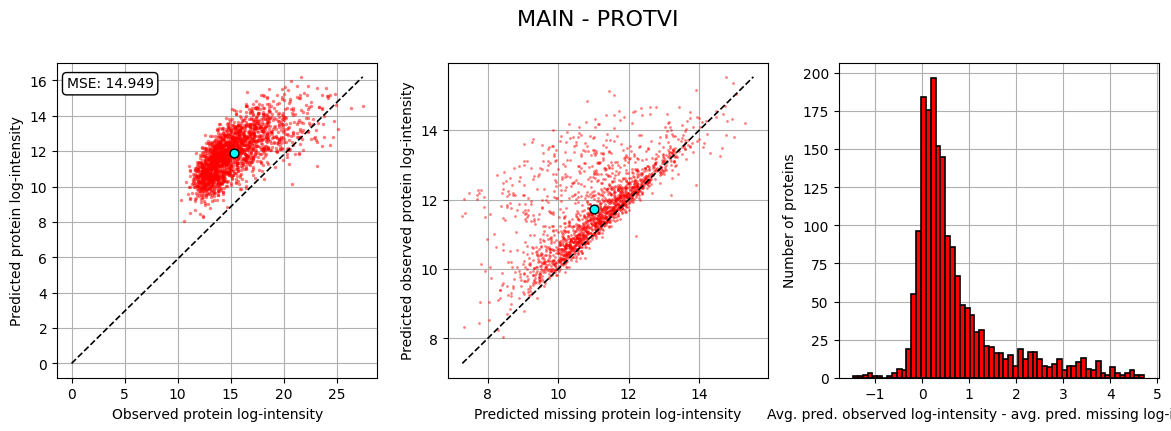

In [12]:
pl.plot_protein_intensity_panel(x_main, x_est, title="MAIN - PROTVI")

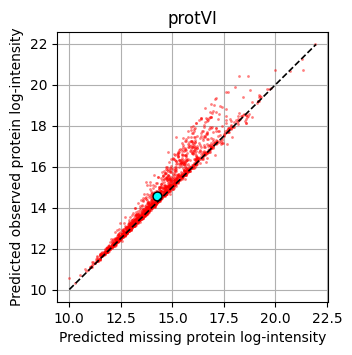

In [12]:
pl.scatter_compare_obs_mis_protein_intensity(x_main, x_est, title="protVI")

In [13]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

In [14]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

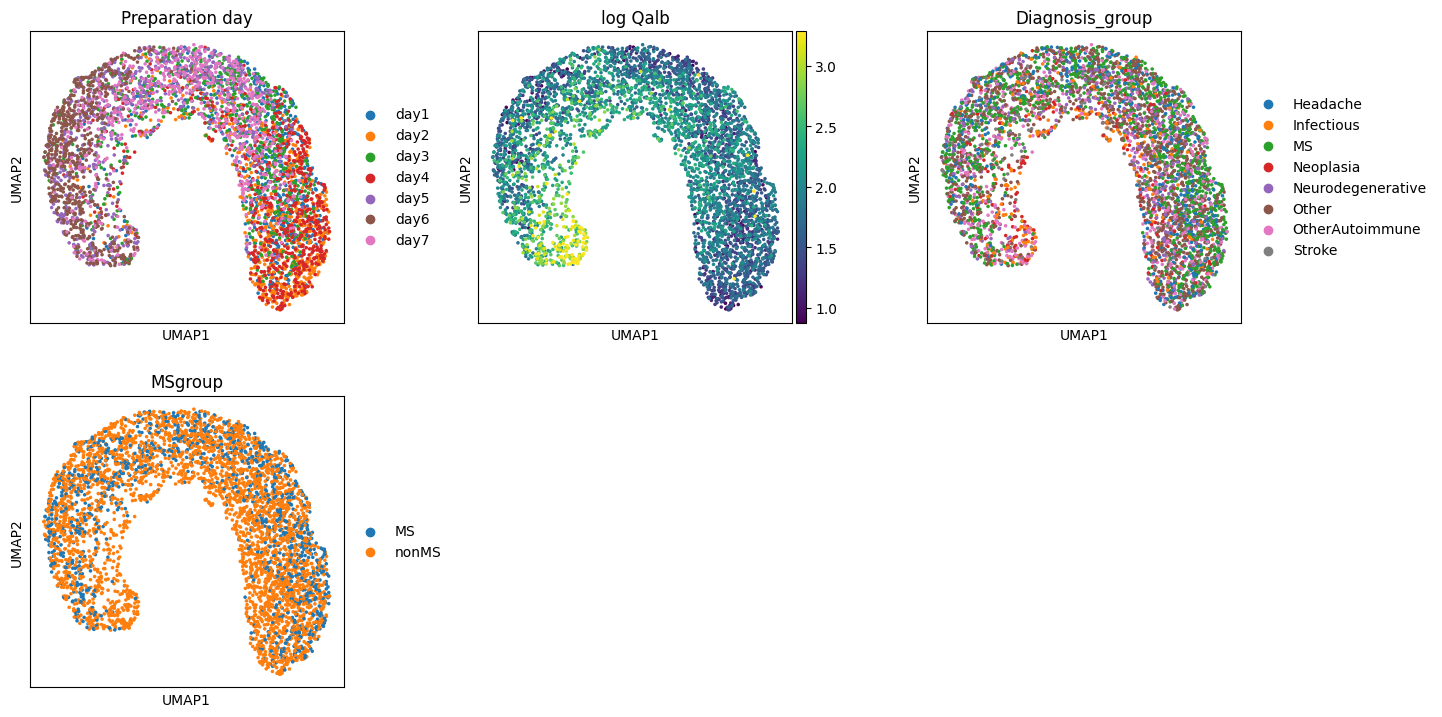

In [15]:
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(
        adata,
        color=["Preparation day", "log Qalb", "Diagnosis_group", "MSgroup"],
        vmin="p01",
        vmax="p99",
        ncols=3,
        wspace=0.3,
    )

In [10]:
da = model.differential_abundance(groupby="MSgroup", batch_correction=True, mode="change")

DE...: 100%|██████████| 2/2 [00:10<00:00,  5.19s/it]


In [9]:
da

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,emp_mean1,emp_mean2,emp_effect,is_de_fdr_0.05,comparison,group1,group2
protein,,,,,,,,,,,,,,,,,,,
Q59EK9-2,0.685594,0.314406,0.779600,17.038836,16.866501,0.0,0.25,0.172326,0.132472,0.690610,-2.828120,2.964528,0.712159,0.598153,0.114006,False,MS vs Rest,MS,Rest
Q5BLP8-2,0.681982,0.318018,0.762897,14.509147,14.407013,0.0,0.25,0.102134,0.098901,0.610112,-2.287422,2.290524,0.883375,0.821567,0.061808,False,MS vs Rest,MS,Rest
Q96RS0,0.680979,0.319021,0.758275,14.960348,14.845723,0.0,0.25,0.114655,0.082387,0.671484,-2.678759,2.783958,0.694789,0.678582,0.016207,False,MS vs Rest,MS,Rest
A3KMH1,0.679374,0.320626,0.750896,14.985184,14.983254,0.0,0.25,0.001923,-0.011533,0.573485,-1.760060,2.243022,0.267990,0.235031,0.032959,False,MS vs Rest,MS,Rest
P01031,0.677167,0.322833,0.740782,17.460684,17.493336,0.0,0.25,-0.032610,-0.031103,0.584527,-1.750418,2.625864,1.000000,1.000000,0.000000,False,MS vs Rest,MS,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8IZJ3,0.062600,0.937400,-2.706339,11.109483,11.130809,0.0,0.25,-0.021323,-0.027105,0.131592,-0.592553,0.597203,0.545725,0.512821,0.032905,False,nonMS vs Rest,nonMS,Rest
P10451-4,0.062400,0.937600,-2.709763,11.797107,11.779325,0.0,0.25,0.017762,0.014984,0.131882,-0.442412,0.652739,0.297289,0.294458,0.002831,False,nonMS vs Rest,nonMS,Rest
O00264,0.057183,0.942817,-2.802616,12.499839,12.519683,0.0,0.25,-0.019839,-0.018350,0.124930,-0.803128,0.558565,0.827525,0.856907,-0.029382,False,nonMS vs Rest,nonMS,Rest
